## Exercise 1 Hello World

1. Write an MPI program displaying the number of processes used for the execution and the rank of each process.
2. Test the programs obtained with different numbers of threads for the parallel program.

**Output Example**
```shell
Hello from the rank 2 process
Hello from the rank 0 process
Hello from the rank 3 process
Hello from the rank 1 process
Parallel execution of hello_world with 4 process
```
*Note that the output order maybe different*

In [1]:
 %%file hello.py
 # write your program here

from mpi4py import MPI

# Communication, Rank, Size
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()
LAST_RANK = SIZE - 1
print("Hello from the rank", RANK, "process")

if RANK == LAST_RANK:
    print("Parallel execution of hello_world with", SIZE, "process")

Writing hello.py


In [2]:
# enter command for compile and run the program
! mpirun -n 4 python hello.py

Hello from the rank 1 process
Hello from the rank 2 process
Hello from the rank 0 process
Hello from the rank 3 process
Parallel execution of hello_world with 4 process


## Exercise 2 Sharing Data 

A common need is for one process to get data from the user, either by reading from the terminal or command line arguments, and then to distribute this information to all other processors.

Write a program that reads an integer value from the terminal and distributes the value to all of the MPI processes. Each process should print out its rank and the value it received. Values should be read until a negative integer is given as input.

You may want to use these MPI routines in your solution:
`Get_rank` `Bcast` 

**Output Example**
```shell
10
Process 0 got 10
Process 1 got 10
```

In [3]:
%%file sharing.py
# write your program here

from mpi4py import MPI
COMM = MPI.COMM_WORLD
RANK = COMM.Get_rank()

import sys
    
if RANK == 0:
    data_to_send = int(sys.argv[1])
else:
    data_to_send = None

recv_data = COMM.bcast(data_to_send, root = 0)
print("The process {rank} got value {value} from 0".format(rank=RANK, value=recv_data))

Writing sharing.py


In [4]:
# enter command for compile and run the program
data = int(input("Type the data to distribute :\n"))

while data >= 0:
    # enter command for compile and run the program
    !mpirun -n 4 python3 sharing.py {data}

    data = int(input("Type the data to distribute :\n"))

Type the data to distribute :
4
The process 0 got value 4 from 0
The process 1 got value 4 from 0
The process 2 got value 4 from 0
The process 3 got value 4 from 0
Type the data to distribute :
3
The process 0 got value 3 from 0
The process 1 got value 3 from 0
The process 2 got value 3 from 0
The process 3 got value 3 from 0
Type the data to distribute :
-1


## Exercise 3 Sending in a ring (broadcast by ring)

Write a program that takes data from process zero and sends it to all of the other processes by sending it in a ring. That is, process i should receive the data and send it to process i+1, until the last process is reached.
Assume that the data consists of a single integer. Process zero reads the data from the user.
![](../data/ring.gif)

You may want to use these MPI routines in your solution:
`Send` `Recv` 

In [5]:
%%file ring.py
# filename = sending_ring.py
from mpi4py import MPI

COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()
LAST_RANK = SIZE - 1
tag = 0
data = 10

if RANK == 0:
    COMM.send(data, dest = RANK + 1, tag = tag)
    print("Process {rank} send data = {data} to process {dest}".format(rank=RANK, data=data, dest=RANK + 1))
    
    
elif RANK < LAST_RANK:
    recv_data = COMM.recv(source = RANK - 1, tag=tag)
    COMM.send(recv_data, dest = RANK + 1, tag = tag)
    print("Process {rank} received data = {data} from process {source} and sends it to process {dest}".format(rank=RANK, data = recv_data, source = RANK -1, dest=RANK + 1))
    
else:
    recv_data = COMM.recv(source = RANK - 1, tag=tag)
    print("Process {rank} receive data = {data} from process {source}".format(rank=RANK, data = recv_data, source = RANK -1))
    

Writing ring.py


In [6]:
!mpirun -n 4 python3 ring.py

Process 0 send data = 10 to process 1
Process 1 received data = 10 from process 0 and sends it to process 2
Process 2 received data = 10 from process 1 and sends it to process 3
Process 3 receive data = 10 from process 2


## Exercise 4 Matrix vector product

1. Use the `MatrixVectorMult.py` file to implement the MPI version of matrix vector multiplication.
2. Process 0 compares the result with the `dot` product.
3. Plot the scalability of your implementation. 

**Output Example**
```shell
CPU time of parallel multiplication using 2 processes is  174.923446
The error comparing to the dot product is : 1.4210854715202004e-14
```

In [7]:
%%file MatrixVectorMult_V0.py

import numpy as np
from scipy.sparse import lil_matrix
from numpy.random import rand, seed
from numba import njit
from mpi4py import MPI


''' This program compute parallel csc matrix vector multiplication using mpi '''

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

seed(42)

def matrixVectorMult(A, b, x):
    
    row, col = A.shape
    for i in range(row):
        a = A[i]
        for j in range(col):
            x[i] += a[j] * b[j]

    return 0

########################initialize matrix A and vector b ######################
#matrix sizes
SIZE = 1000
Local_size = int(SIZE/nbOfproc) 

# counts = block of each proc
counts = counts =[Local_size*SIZE for i in range(nbOfproc)]

if RANK == 0:
    A = lil_matrix((SIZE, SIZE))
    A[0, :100] = rand(100)
    A[1, 100:200] = A[0, :100]
    A.setdiag(rand(SIZE))
    A = A.toarray()
    b = rand(SIZE)
else :
    A = None
    b = None



# Send b to all procs
b = COMM.bcast(b, root=0)
LocalMatrix = np.zeros((Local_size, SIZE))

# Scatter the matrix A
COMM.Scatterv([A, counts, MPI.DOUBLE], LocalMatrix, root = 0)

#####################Compute A*b locally#######################################
LocalX = np.zeros(Local_size)

start = MPI.Wtime()
matrixVectorMult(LocalMatrix, b, LocalX)
stop = MPI.Wtime()

if RANK == 0:
    print("CPU time of parallel multiplication is ", (stop - start)*1000)

##################Gather te results ###########################################
# sendcouns = local size of result
sendcounts = np.array([Local_size for i in range(nbOfproc)])
if RANK == 0: 
    X = np.empty(sum(sendcounts), dtype=np.double)
else :
    X = None

# Gather the result into X
COMM.Gatherv(LocalX, (X, sendcounts, MPI.DOUBLE), root=0)

##################Print the results ###########################################

if RANK == 0 :
    X_ = A.dot(b)
    print("The error is :", np.max(X_ - X))
    #print("The result of A*b using dot is :", X_)
    #print("The result of A*b using parallel version is :", X)


Writing MatrixVectorMult_V0.py


In [22]:
!mpirun -n 2 python3 MatrixVectorMult_V0.py

CPU time of parallel multiplication is  474.81834500013065
The error is : 1.4210854715202004e-14


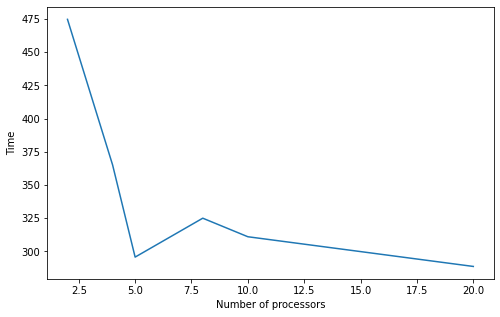

In [24]:
import matplotlib.pyplot as plt

nb_proc = [2, 4, 5, 8, 10, 20]
times = [474.81834500013065, 365.1421700001265, 295.6487400001606, 324.96612200020536, 310.9891599997354, 288.6031219995857]
plt.figure(figsize=(8, 5))
plt.plot(nb_proc, times)
plt.xlabel("Number of processors")
plt.ylabel("Time")
plt.show()

## Exercise 5 Calculation of π (Monte Carlo)

1. Use the `PiMonteCarlo.py` file to implement the calculation of PI using Monte Carlo.
2. Process 0 prints the result.
3. Plot the scalability of your implementation. 

In [15]:
%%file PiMonteCarlo_V0.py
# write your program here

import numpy as np
import random 
import timeit
from mpi4py import MPI

COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

INTERVAL= 1000
random.seed(42)  

if RANK == 0:
    values_sum = np.array([0.])
else:
    values_sum = None
    
def compute_points():
    
    random.seed(42)  
    
    circle_points= np.array([0.])

    # Total Random numbers generated= possible x 
    # values* possible y values 
    num_rank = int(INTERVAL**2 / SIZE)
    inf_val = 1 + (RANK * num_rank)
    sup_val = 1 + (RANK +1) * num_rank

    COMM.Barrier()
    for i in range(inf_val, sup_val): 
      
        # Randomly generated x and y values from a 
        # uniform distribution 
        # Rannge of x and y values is -1 to 1 
                
        rand_x= random.uniform(-1, 1) 
        rand_y= random.uniform(-1, 1) 
      
        # Distance between (x, y) from the origin 
        origin_dist= rand_x**2 + rand_y**2
      
        # Checking if (x, y) lies inside the circle 
        if origin_dist<= 1: 
            circle_points[0] += 1
      
        # Estimating value of pi, 
        # pi= 4*(no. of points generated inside the  
        # circle)/ (no. of points generated inside the square) 
    
         
    COMM.Barrier()
    
    # Get partial results from all processors then calculate the sum
    COMM.Reduce(circle_points, values_sum, op=MPI.SUM, root=0)
    
    return values_sum



start = timeit.default_timer()
circle_points = compute_points()
end = timeit.default_timer()

if RANK == 0:
    print("I am process 0")
    pi = 4* circle_points[0]/ INTERVAL**2 
    print("Circle points number :",circle_points[0])
    print("Final Estimation of Pi=", pi, "cpu time :",end-start)

Writing PiMonteCarlo_V0.py


In [16]:
!mpirun -n 2 python3 PiMonteCarlo_V0.py

I am process 0
Circle points number : 785596.0
Final Estimation of Pi= 3.142384 cpu time : 0.9252625959998113


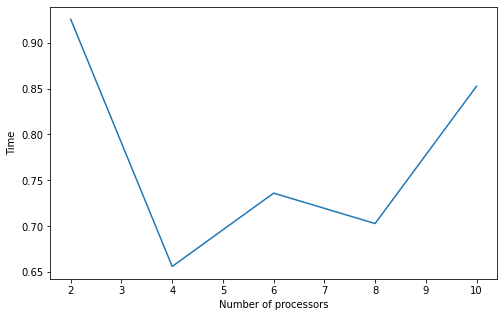

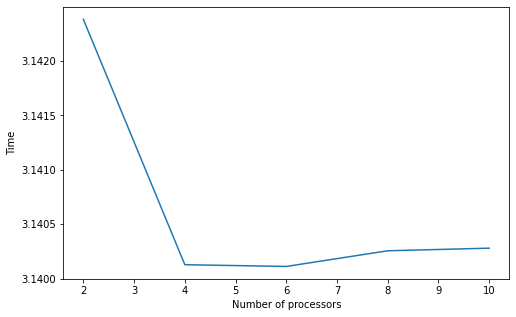

In [25]:
import matplotlib.pyplot as plt

nb_proc = [2, 4, 6, 8, 10]
times = [0.9252625959998113, 0.6563518330003717, 0.73613126500004, 0.703037511999355, 0.8525159130003885]
estimated_values = [3.142384, 3.140128, 3.140112, 3.140256, 3.14028]


plt.figure(figsize=(8, 5))
plt.plot(nb_proc, times)
plt.xlabel("Number of processors")
plt.ylabel("Time")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(nb_proc, estimated_values)
plt.xlabel("Number of processors")
plt.ylabel("Time")
plt.show()